In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

/Users/fredshone/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Predicting Bike Checkout - Without Weather Forecast
Training of a variety of models for predicting bike checkouts (currently set up for three hours into the future). In this workbook it is assumed that weather data is NOT known ahead of the time the prediction is made(ie it is assumed that there is no forecast data)
#### Methodology
Three years of data are used for training and validation. There is currently no test. Intention is to wait for new data. 2015 and 2016 data is used for training. 2017 data is used for validation. This is a large validation set but provides validation against a wide variety of seasonal variation.
Data is standardised to mean of zero and single standard deviation.
Mean Absolute Error is used to compare senarios.

          -------time---------------------------------------->
          
raw data------------------1---1---1---0---2---1---4---1---4---4---6---5---2---2---1---0---0---1--

          
known data---------------1---1---1---0---2---1---4---1---4---4---6---5---2---2-----------------

          
unknown data------------1---1---1---0---2---1---4---1---4-------------------------------

          -------time---------------------------------------->
                ^                          ^              ^
                |                          |              |
                |   <----lookback----->    |  <--delay--> |
                |   <------------known data-------------> |
                |   <--unknown data--->    |              |
                |                          |              |
                                time of prediction    prediction
#### Benchmarking
Two simple benchmarks are created: prediction using previous day and prediction using previos same-day. MAEs are around 0.3 standard deviations - approx. ten checkout counts.
#### Results
A simple fully connected model offers no improvement over the benchmarks.
A number of recurrent networks (GRU and LSTM) are trained - best validation MAE is approx. 0.2 standard deviations or six checkout counts.
#### Notes
Prediction performance doesn't dip much below the 'known' scenario, where weather data is available up to the prediction time.
Better performance is achieved with heavier models with larger, more complex and more layers, but improvements are minor.
Need to try different periods of lookback.

In [122]:
def standardise(_array):
    array = _array.copy()
    mean = array.mean(axis=0)
    array -= mean
    std = array.std(axis=0)
    array /= std
    return array

In [ ]:
def split(df):
    y = np.array(df['Checkout_count'],
                 dtype='float64')
    Xk = np.array(df[['month', 'weekday', 'hour',
                      'Holiday', 'Teaching_term', 'Study_Holidays', 'Exam_Period', 'Holidays_Period']],
                  dtype='float64')
    Xu = np.array(df[['Checkout_count',
                      'rain', 'temp', 'humidity', 'wind_speed', 'visibility', 'cloud_amount']],
                  dtype='float64')
    return Xk, Xu, y   

In [160]:
def generator(_y, _Xk, _Xu, lookback, delay, batch_size=128, step=1):
    """Method to generate batches of """
    max_index = len(_y) - delay - 1
    i = lookback - 1
    while True:
        end_index = min(i + batch_size, max_index)       
        rows = np.arange(i, end_index)
        length = len(rows)     
        #print('{}-->{} ({})'.format(i, end_index, length))          
        i += length        
        if i >= max_index:
            #print('> all data seen')
            i = lookback    
        y = np.zeros((len(rows),))
        Xk = np.zeros((len(rows),
                      (lookback + delay) // step,
                      _Xk.shape[-1]))
        Xu = np.zeros((len(rows),
                       (lookback + delay) // step,
                       _Xu.shape[-1]))
        for j, row in enumerate(rows):
            y[j] = _y[rows[j] + delay]
            known_indices = range(rows[j] - lookback, rows[j] + delay, step)
            Xk[j] = _Xk[known_indices]
            unknown_indices = range(rows[j] - lookback, rows[j], step)
            Xu[j,:(lookback//step)] = _Xu[unknown_indices]
        X = np.concatenate((Xu, Xk), axis=2)
            
        yield X, y    

In [185]:
df_raw = pd.read_csv(os.path.join('data', 'bike_share_hours.csv'))
df = df_raw.drop('date', axis=1)

In [189]:
mean = df.mean(axis=0)
std = df.std(axis=0)
df_standardised = standardise(df)

In [163]:
lookback = 7 * 24
delay = 3
step = 1
batch_size = 128

In [164]:
df_standardised.describe()

,Unnamed: 0,year,month,day,weekday,week,hour,Checkout_count,rain,temp,humidity,wind_speed,wind_direction,visibility,cloud_amount,Holiday,Teaching_term,Study_Holidays,Exam_Period,Holidays_Period
count,2.629800e+04,2.629800e+04,2.629800e+04,2.629800e+04,2.629800e+04,2.629800e+04,2.629800e+04,2.629800e+04,2.629800e+04,2.629800e+04,2.629800e+04,2.629800e+04,2.629800e+04,2.629800e+04,2.629800e+04,2.629800e+04,2.629800e+04,2.629800e+04,2.629800e+04,2.629800e+04
mean,1.729209e-17,-1.729209e-17,8.646044e-17,5.619929e-17,-1.567096e-17,-5.187627e-17,1.293529e-17,-4.214947e-17,6.377538e-15,2.718749e-14,-3.761029e-16,3.296304e-17,8.646044e-17,3.458418e-17,-7.943553e-17,9.834875e-17,1.902130e-16,-4.971476e-17,1.383367e-16,8.646044e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.731952e+00,-1.225211e+00,-1.600997e+00,-1.673982e+00,-1.502986e+00,-1.708021e+00,-1.661831e+00,-9.968580e-01,-2.618729e-01,-2.876356e+00,-4.745870e+00,-1.886504e+00,-2.598461e+00,-1.720343e+00,-2.436319e+00,-1.677740e-01,-8.973755e-01,-1.706274e-01,-2.749181e-01,-8.976517e-01
25%,-8.659760e-01,-1.225211e+00,-7.311898e-01,-8.786095e-01,-1.002866e+00,-8.453565e-01,-7.949608e-01,-8.801305e-01,-2.618729e-01,-6.895556e-01,-5.246522e-01,-7.188683e-01,-6.638192e-01,-5.164802e-01,-7.393280e-01,-1.677740e-01,-8.973755e-01,-1.706274e-01,-2.749181e-01,-8.976517e-01
50%,0.000000e+00,0.000000e+00,1.386175e-01,3.038716e-02,-2.624407e-03,1.730758e-02,7.190957e-02,-2.381290e-01,-2.618729e-01,8.640569e-02,2.351670e-01,-1.350505e-01,1.825865e-01,8.847620e-02,5.334151e-01,-1.677740e-01,-8.973755e-01,-1.706274e-01,-2.749181e-01,-8.976517e-01
75%,8.659760e-01,1.225211e+00,1.008425e+00,8.257592e-01,9.976168e-01,8.799717e-01,9.387800e-01,5.497819e-01,-2.618729e-01,7.212832e-01,8.261376e-01,6.433732e-01,7.871619e-01,6.934326e-01,5.334151e-01,-1.677740e-01,1.114318e+00,-1.706274e-01,-2.749181e-01,1.113975e+00
max,1.731952e+00,1.225211e+00,1.588296e+00,1.734756e+00,1.497737e+00,1.742636e+00,1.661172e+00,5.014610e+00,2.648694e+01,3.284307e+00,1.079411e+00,6.481551e+00,1.754483e+00,2.810780e+00,9.576628e-01,5.960172e+00,1.114318e+00,5.860501e+00,3.637309e+00,1.113975e+00


In [165]:
df_train = df_standardise[(df.year == 2015) | (df.year == 2016)]
len(df_train)

17539

In [166]:
df_validate = df_standardise[df.year == 2017]
len(df_validate)

8759

In [167]:
Xk_train, Xu_train, y_train = split(df_train)
Xk_validate, Xu_validate, y_validate = split(df_validate)

In [ ]:
lookback = 7 * 24
delay = 3
step = 1
batch_size = 128

In [168]:
training_gen = generator(y_train, Xk_train, Xu_train,
                         lookback, delay)
num_training_batches = int((len(df_train) - lookback - delay) / batch_size)
validation_gen = generator(y_validate, Xk_validate, Xu_validate,
                         lookback, delay)
num_validation_samples = int((len(df_validate) - lookback - delay) / batch_size)

## Benchmarking
Benchmarking with some relatively naive methods:
1. predicting using checkouts from 7 days ago
2. pedicting using checkouts from 24 hours ago

In [190]:
def eval_naive(samples, gen, index):
    maes = []
    for i in range(samples):
        X, y = next(gen)
        preds = X[:, index, 0]
        mae = np.mean(np.abs(preds - y))
        maes.append(mae)
    return np.mean(maes)

In [177]:
# Sample from 7 days ago
eval_naive(num_validation_samples, validation_gen, delay) * df.Checkout_count.std()

10.381402645861133

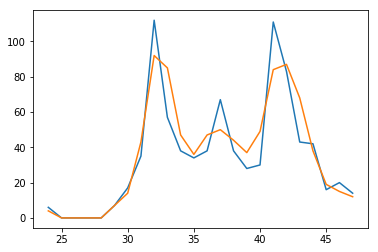

In [218]:
date = '2017-08-30'
sample = list(df_raw.index[df_raw.date == date])
actuals = [None] * len(sample)
preds = [None] * len(sample)
for index in sample:
    actual = df_raw.Checkout_count.iloc[(index)]
    pred = df_raw.Checkout_count.iloc[(index-(24*7))]
    actuals.append(actual)
    preds.append(pred)
plt.plot(actuals)
plt.plot(preds)    

In [178]:
# Sample from 1 day ago
eval_naive(num_validation_samples, validation_gen, -24) * df.Checkout_count.std()

12.949383056308774

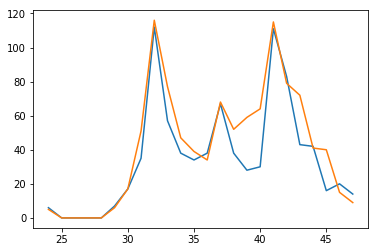

In [219]:
date = '2017-08-30'
sample = list(df_raw.index[df_raw.date == date])
actuals = [None] * len(sample)
preds = [None] * len(sample)
for index in sample:
    actual = df_raw.Checkout_count.iloc[(index)]
    pred = df_raw.Checkout_count.iloc[(index-24)]
    actuals.append(actual)
    preds.append(pred)
plt.plot(actuals)
plt.plot(preds)   

In [223]:
model = Sequential()
model.add(layers.Flatten(input_shape=((lookback + delay)// step, 15)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

In [224]:
model.compile(optimizer=RMSprop(),loss='mae')
hist = model.fit_generator(training_gen,
                          steps_per_epoch=500,
                          epochs = 20,
                          validation_data= validation_gen,
                          validation_steps=num_validation_samples)

Epoch 1/20
500/500 [==============================] - 11s 23ms/step - loss: 1.8273 - val_loss: 0.7279
Epoch 2/20
500/500 [==============================] - 7s 13ms/step - loss: 1.1154 - val_loss: 0.6185
Epoch 3/20
500/500 [==============================] - 7s 14ms/step - loss: 0.9845 - val_loss: 0.5689
Epoch 4/20
500/500 [==============================] - 7s 13ms/step - loss: 0.8220 - val_loss: 0.4866
Epoch 5/20
500/500 [==============================] - 7s 13ms/step - loss: 0.7095 - val_loss: 0.7922
Epoch 6/20
500/500 [==============================] - 7s 13ms/step - loss: 0.7732 - val_loss: 0.6557
Epoch 7/20
500/500 [==============================] - 7s 14ms/step - loss: 0.6884 - val_loss: 0.4292
Epoch 8/20
500/500 [==============================] - 7s 14ms/step - loss: 0.6447 - val_loss: 0.4683
Epoch 9/20
500/500 [==============================] - 7s 13ms/step - loss: 0.6591 - val_loss: 0.4390
Epoch 10/20
500/500 [==============================] - 7s 13ms/step - loss: 0.6477 - val_l

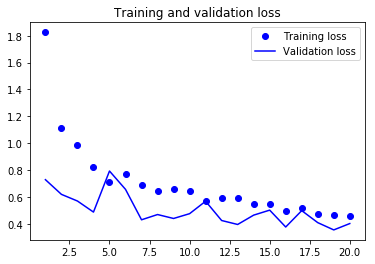

In [225]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [227]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, 15)))
model.add(layers.Dense(1))

In [229]:
model.compile(optimizer=RMSprop(),loss='mae')
hist = model.fit_generator(training_gen,
                          steps_per_epoch=500,
                          epochs = 20,
                          validation_data= validation_gen,
                          validation_steps=num_validation_samples)

Epoch 1/20
500/500 [==============================] - 60s 119ms/step - loss: 0.3757 - val_loss: 0.3863
Epoch 2/20
500/500 [==============================] - 56s 112ms/step - loss: 0.3397 - val_loss: 0.3661
Epoch 3/20
500/500 [==============================] - 56s 112ms/step - loss: 0.3283 - val_loss: 0.3301
Epoch 4/20
500/500 [==============================] - 56s 112ms/step - loss: 0.3066 - val_loss: 0.3374
Epoch 5/20
500/500 [==============================] - 56s 112ms/step - loss: 0.2794 - val_loss: 0.2931
Epoch 6/20
500/500 [==============================] - 56s 112ms/step - loss: 0.2505 - val_loss: 0.2801
Epoch 7/20
500/500 [==============================] - 56s 111ms/step - loss: 0.2333 - val_loss: 0.2583
Epoch 8/20
500/500 [==============================] - 55s 111ms/step - loss: 0.2219 - val_loss: 0.2759
Epoch 9/20
500/500 [==============================] - 56s 112ms/step - loss: 0.2161 - val_loss: 0.2758
Epoch 10/20
500/500 [==============================] - 56s 112ms/step - l

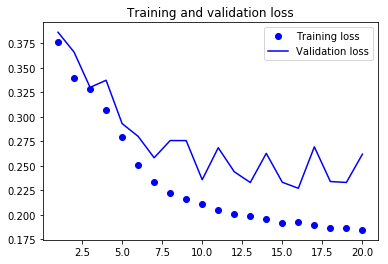

In [231]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [232]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, 15)))
model.add(layers.GRU(64, activation='relu',
                    dropout=0.1,
                    recurrent_dropout=0.5))
model.add(layers.Dense(1))

In [233]:
model.compile(optimizer=RMSprop(),loss='mae')
hist = model.fit_generator(training_gen,
                          steps_per_epoch=500,
                          epochs = 40,
                          validation_data= validation_gen,
                          validation_steps=num_validation_samples)

Epoch 1/40
500/500 [==============================] - 137s 275ms/step - loss: 0.4844 - val_loss: 0.3926
Epoch 2/40
500/500 [==============================] - 135s 270ms/step - loss: 0.4054 - val_loss: 0.3412
Epoch 3/40
500/500 [==============================] - 133s 266ms/step - loss: 0.3626 - val_loss: 0.3093
Epoch 4/40
500/500 [==============================] - 133s 266ms/step - loss: 0.3365 - val_loss: 0.3005
Epoch 5/40
500/500 [==============================] - 133s 266ms/step - loss: 0.3245 - val_loss: 0.2761
Epoch 6/40
500/500 [==============================] - 139s 278ms/step - loss: 0.3072 - val_loss: 0.2624
Epoch 7/40
500/500 [==============================] - 148s 296ms/step - loss: 0.2977 - val_loss: 0.2877
Epoch 8/40
500/500 [==============================] - 141s 281ms/step - loss: 0.2919 - val_loss: 0.2355
Epoch 9/40
500/500 [==============================] - 136s 272ms/step - loss: 0.2857 - val_loss: 0.2315
Epoch 10/40
500/500 [==============================] - 131s 261m

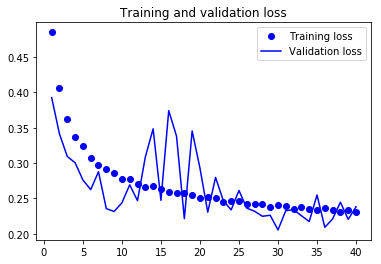

In [234]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [237]:
model = Sequential()
model.add(layers.LSTM(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, 15)))
model.add(layers.GRU(64, activation='relu',
                    dropout=0.1,
                    recurrent_dropout=0.5))
model.add(layers.Dense(1))

In [238]:
model.compile(optimizer=RMSprop(),loss='mae')
hist = model.fit_generator(training_gen,
                          steps_per_epoch=500,
                          epochs = 40,
                          validation_data= validation_gen,
                          validation_steps=num_validation_samples)

Epoch 1/40
500/500 [==============================] - 229s 458ms/step - loss: 0.4926 - val_loss: 0.5106
Epoch 2/40
500/500 [==============================] - 213s 427ms/step - loss: 0.3785 - val_loss: 0.4589
Epoch 3/40
500/500 [==============================] - 208s 417ms/step - loss: 0.3394 - val_loss: 0.2686
Epoch 4/40
500/500 [==============================] - 210s 420ms/step - loss: 0.3126 - val_loss: 0.3643
Epoch 5/40
500/500 [==============================] - 205s 409ms/step - loss: 0.2925 - val_loss: 0.3246
Epoch 6/40
500/500 [==============================] - 210s 419ms/step - loss: 0.2832 - val_loss: 0.2439
Epoch 7/40
500/500 [==============================] - 202s 404ms/step - loss: 0.2759 - val_loss: 0.2991
Epoch 8/40
500/500 [==============================] - 202s 404ms/step - loss: 0.2647 - val_loss: 0.2476
Epoch 9/40
500/500 [==============================] - 202s 405ms/step - loss: 0.2609 - val_loss: 0.2221
Epoch 10/40
500/500 [==============================] - 208s 416m

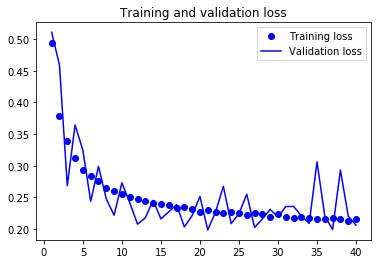

In [239]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [240]:
model = Sequential()
model.add(layers.LSTM(64,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, 15)))
model.add(layers.GRU(128, activation='relu',
                    dropout=0.1,
                    recurrent_dropout=0.5))
model.add(layers.Dense(1))

In [241]:
model.compile(optimizer=RMSprop(),loss='mae')
hist = model.fit_generator(training_gen,
                          steps_per_epoch=500,
                          epochs = 40,
                          validation_data= validation_gen,
                          validation_steps=num_validation_samples)

Epoch 1/40
500/500 [==============================] - 363s 726ms/step - loss: 0.4285 - val_loss: 0.3109
Epoch 2/40
500/500 [==============================] - 359s 718ms/step - loss: 0.3178 - val_loss: 0.2589
Epoch 3/40
500/500 [==============================] - 361s 722ms/step - loss: 0.2914 - val_loss: 0.2672
Epoch 4/40
500/500 [==============================] - 363s 726ms/step - loss: 0.2753 - val_loss: 0.2524
Epoch 5/40
500/500 [==============================] - 365s 731ms/step - loss: 0.2613 - val_loss: 0.2508
Epoch 6/40
500/500 [==============================] - 367s 734ms/step - loss: 0.2547 - val_loss: 0.2566
Epoch 7/40
500/500 [==============================] - 366s 732ms/step - loss: 0.2481 - val_loss: 0.2168
Epoch 8/40
500/500 [==============================] - 374s 747ms/step - loss: 0.2406 - val_loss: 0.2490
Epoch 9/40
500/500 [==============================] - 375s 751ms/step - loss: 0.2386 - val_loss: 0.2059
Epoch 10/40
500/500 [==============================] - 373s 746m

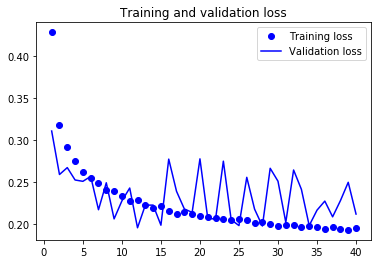

In [242]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [243]:
model = Sequential()
model.add(layers.LSTM(32,
                      input_shape=(None, 15)))
model.add(layers.Dense(1))

In [244]:
model.compile(optimizer=RMSprop(),loss='mae')
hist = model.fit_generator(training_gen,
                          steps_per_epoch=500,
                          epochs = 20,
                          validation_data= validation_gen,
                          validation_steps=num_validation_samples)

Epoch 1/20
500/500 [==============================] - 73s 146ms/step - loss: 0.4489 - val_loss: 0.3907
Epoch 2/20
500/500 [==============================] - 68s 136ms/step - loss: 0.3207 - val_loss: 0.3403
Epoch 3/20
500/500 [==============================] - 67s 135ms/step - loss: 0.2818 - val_loss: 0.2781
Epoch 4/20
500/500 [==============================] - 67s 135ms/step - loss: 0.2447 - val_loss: 0.2715
Epoch 5/20
500/500 [==============================] - 68s 135ms/step - loss: 0.2222 - val_loss: 0.2968
Epoch 6/20
500/500 [==============================] - 68s 135ms/step - loss: 0.2136 - val_loss: 0.2444
Epoch 7/20
500/500 [==============================] - 67s 135ms/step - loss: 0.2080 - val_loss: 0.2409
Epoch 8/20
500/500 [==============================] - 67s 134ms/step - loss: 0.2020 - val_loss: 0.3068
Epoch 9/20
500/500 [==============================] - 67s 134ms/step - loss: 0.1988 - val_loss: 0.2275
Epoch 10/20
500/500 [==============================] - 67s 134ms/step - l

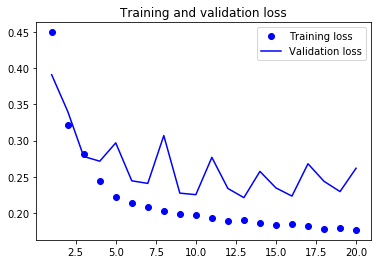

In [245]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()